In [1]:

import uns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
def colormap(N): 
    return colors.ListedColormap(plt.cm.plasma(np.linspace(0,1,N)))
from mpl_toolkits.mplot3d import Axes3D

training = pd.read_msgpack('training.bin')
training.columns

chrisv on Mac


Index(['centcol', 'centrow', 'contH', 'contW', 'contour', 'contxmax',
       'contxmin', 'contymax', 'contymin', 'hasmask', 'img', 'maskarea',
       'moment_hu_I0', 'moment_hu_I1', 'moment_hu_I2', 'moment_hu_I3',
       'moment_hu_I4', 'moment_hu_I5', 'moment_hu_I6', 'moments', 'pixels',
       'skelavgdist', 'skeldist10', 'skeldist25', 'skeldist50', 'skeldist75',
       'skeldist90', 'skelmaxdist', 'skelpixels', 'subject', 'svd', 'svdx0',
       'svdx1', 'svdy0', 'svdy1', 'unitcontour', 'sv0', 'sv1', 'sv2', 'sv3'],
      dtype='object')

# Prepare the numeric array

In [161]:
Columns = [#'centrow', 'contH', 'contW', 'contymax', 'contymin', 
           'maskarea',
           #'skelavgdist', 
           'skeldist10', 
           #'skeldist25',
           #'skeldist50', 
           #'skeldist75', 
           #'skeldist90', 
           #'skelmaxdist', 
           #'skelpixels',
           #'moment_hu_I0', 'moment_hu_I1',
           #'moment_hu_I2', 'moment_hu_I3', 'moment_hu_I4', 'moment_hu_I5', 'moment_hu_I6',
           'svdx0', 'svdx1', 'svdy0', 'svdy1',
           #'sv0', 'sv1', 'sv2', 'sv3'
            ]

data = training[training['hasmask']][Columns]
data.head(10)

maskarea  skeldist10     svdx0     svdx1     svdy0     svdy1
0   0.137656    0.003448 -0.288255  0.144863  0.233198  0.179064
1   0.160957    0.003855 -0.406344  0.085061  0.132856  0.260161
2   0.181390    0.004877 -0.368935  0.193910  0.286360  0.249826
3   0.125667    0.003448 -0.297458 -0.018831 -0.023345  0.239933
6   0.155641    0.003855 -0.374071  0.084245  0.118007  0.267049
13  0.171849    0.004877 -0.281118  0.236596  0.295410  0.225149
14  0.127306    0.003448 -0.292360 -0.020699 -0.024171  0.250367
16  0.140475    0.003855 -0.314163  0.084060  0.102150  0.258527
19  0.157450    0.003855 -0.374265  0.063109  0.082174  0.287432
22  0.173158    0.004877 -0.294351  0.231656  0.260556  0.261702

In [162]:
#training.loc[3667,'hasmask'] = False
#training.to_msgpack('training.bin')


In [163]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
#X = data.values
X = StandardScaler().fit_transform(data.values)
P = pca.fit(X)
pca.explained_variance_ratio_


array([ 0.35560471,  0.33662345,  0.15394943,  0.0974494 ,  0.03307411,
        0.0232989 ])

In [164]:
pft = P.fit_transform(X)

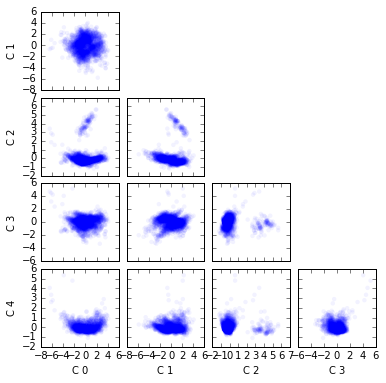

In [167]:
def plot_pca_comps(P, ncomp, *args, **kwargs):
    nplots = ncomp-1
    fig, ax = plt.subplots(nrows=nplots, ncols=nplots,
                           sharey='row', sharex='col',
                           figsize=kwargs.pop('figsize',(6,6)))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i, row in enumerate(ax):
        for j, axij in enumerate(row):
            axij.scatter(P[:,j], P[:,i+1], *args, **kwargs)
            if j>i: 
                axij.remove()

    # Label outer axes
    for i in range(nplots):
        ax[i,0].set_ylabel('C {}'.format(i+1))
        ax[nplots-1,i].set_xlabel('C {}'.format(i))


fig = plot_pca_comps(pft, 5, alpha=0.05, edgecolors='none')


## Clustering

In [168]:
from sklearn import cluster
kmc = cluster.KMeans(n_clusters=3).fit_predict(pft)

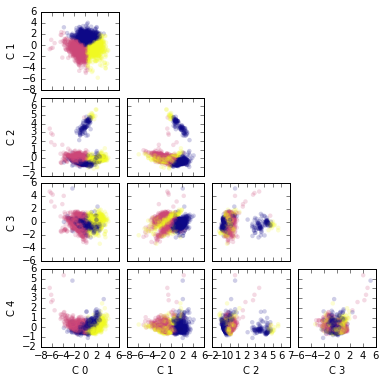

In [169]:
fig = plot_pca_comps(pft, 5, 
               alpha=0.2, 
               edgecolors='none', 
               color=kmc, 
               cmap=colormap(len(set(kmc))))

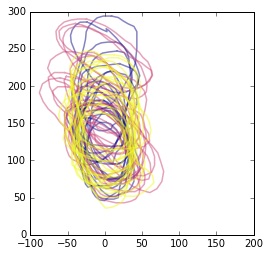

In [197]:
training.loc[training['hasmask'],'KMeansCluster'] = kmc


def plot_group_masks(groupby, ax=None, n=50, split=False):
    clusters = training[training['hasmask']].groupby(by=groupby)
    ncol = len(clusters)
    col = colormap(ncol)
    
    if ax is None:
        if not split:
            fig, ax = plt.subplots()
    for i, (key, group) in enumerate(clusters):
        color = col.colors[i,:]
        if split:
            fig, ax = plt.subplots()
        sub = group.sample(n=min(n,len(group)))[['centcol','contour','unitcontour','centrow']]
        D = np.dstack(sub['contour'].values)
        C = np.dstack(sub['centcol'].values)
        ax.plot(D[1,:,:]-C[0,:,:]*580,D[0,:,:], color=color, alpha=0.5, lw=1.5)
        
    ax.axis('square')
    return col
col = plot_group_masks(groupby='KMeansCluster', n=20)

array([ 0.798216,  0.280197,  0.469538,  1.      ])

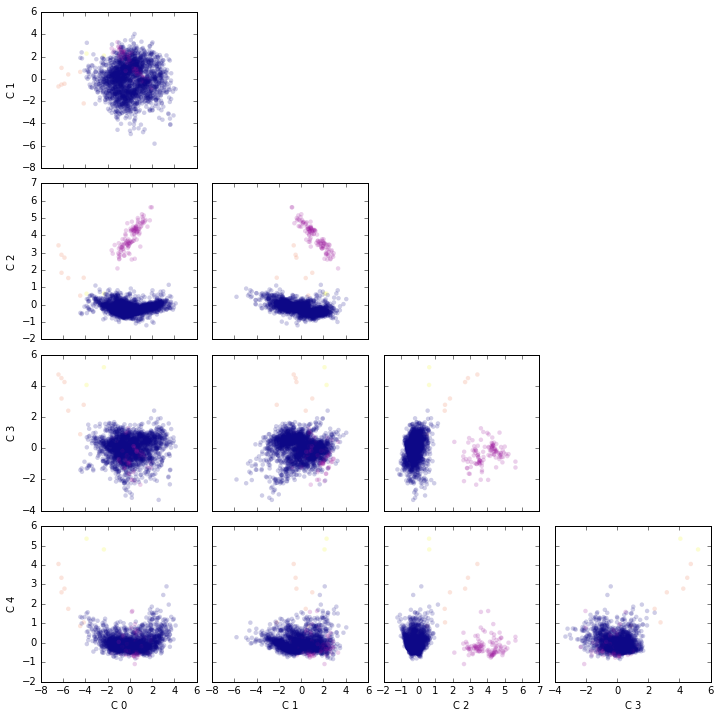

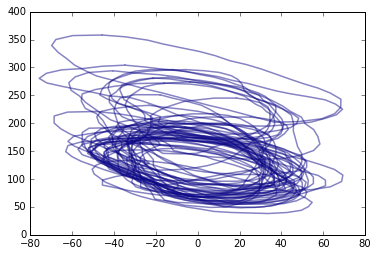

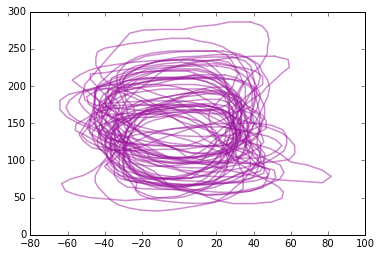

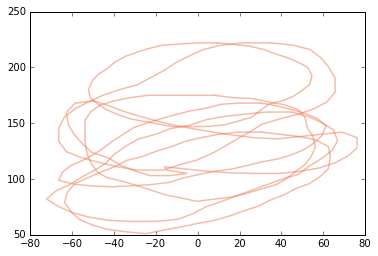

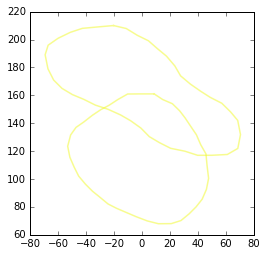

In [198]:
bandwidth = cluster.estimate_bandwidth(X, quantile=.3, n_samples=50)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(P.transform(X))
labels = ms.labels_+1
training.loc[training['hasmask'],'MeanShift'] = labels

plot_pca_comps(pft, 5, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=ms.labels_, 
               cmap=colormap(len(set(labels)))
              )

plot_group_masks(groupby='MeanShift',split=True)

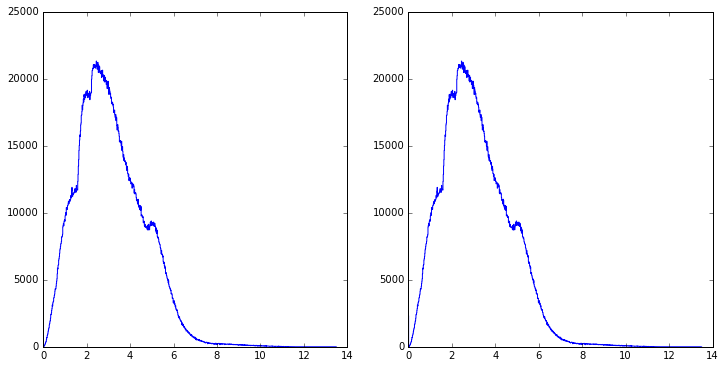

In [173]:
from sklearn import metrics
DX = metrics.pairwise_distances(X)
DPX = metrics.pairwise_distances(P.transform(X))
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(DX.flatten(), bins=1000, histtype='step')
ax[1].hist(DPX.flatten(),bins=1000, histtype='step')
plt.show()

Found 3 clusters


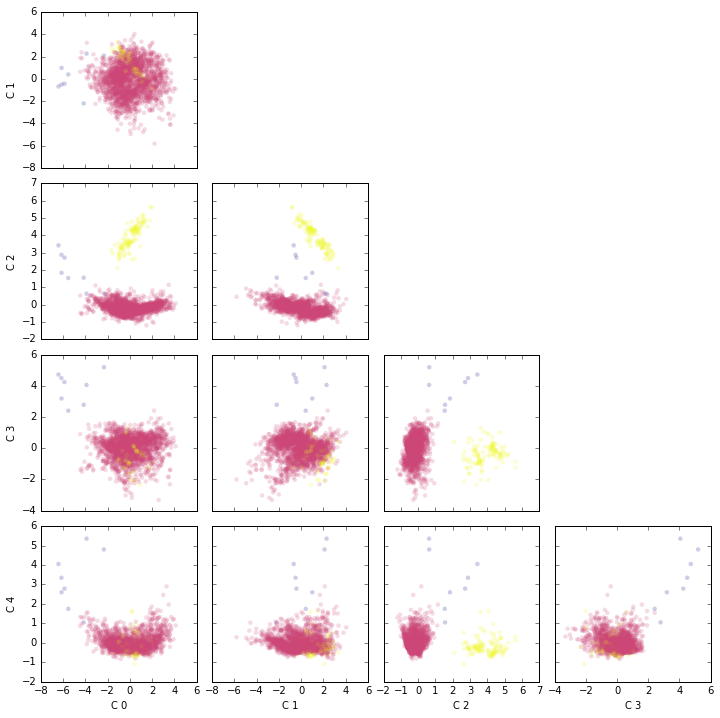

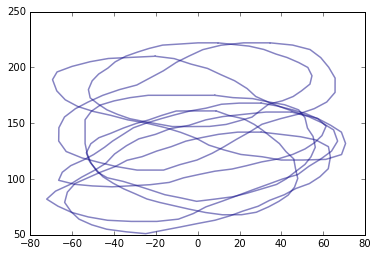

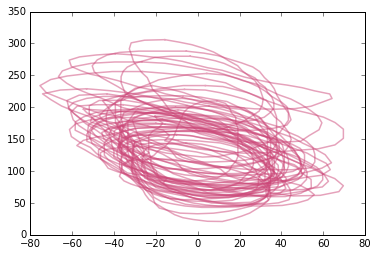

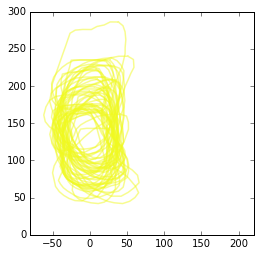

In [199]:
db = cluster.DBSCAN(eps=2, min_samples=15)
db.fit(pft)
labels = db.labels_
training.loc[training['hasmask'],'DBSCAN'] = labels

print('Found {:d} clusters'.format(len(set(labels))))
plot_pca_comps(pft, 5, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=colormap(len(set(labels))))

plot_group_masks(groupby='DBSCAN', split=True)

In [176]:
def plot_pca3d(angle1, angle2):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(pft[:,0],pft[:,1],pft[:,2], c=labels, alpha=0.5, cmap=colormap(len(set(labels))), edgecolors='none')
    ax.view_init(angle2,angle1)




In [200]:
ac = cluster.AgglomerativeClustering(n_clusters=5)
ac.fit(pft)
labels = ac.labels_
training.loc[training['hasmask'],'AgglomerativeClustering'] = labels

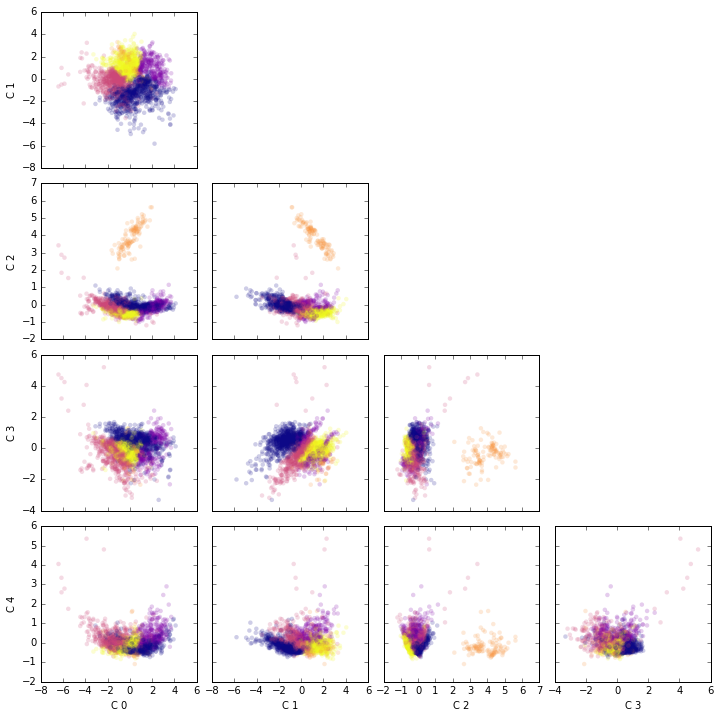

In [201]:
plot_pca_comps(pft, 5, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=colormap(len(set(labels))))

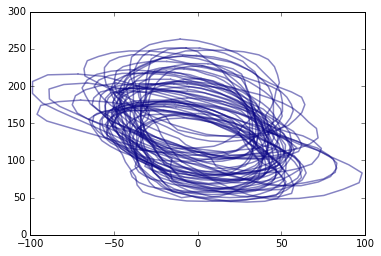

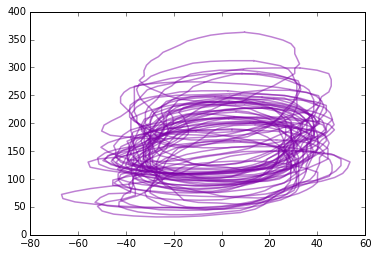

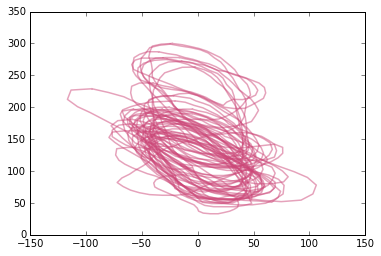

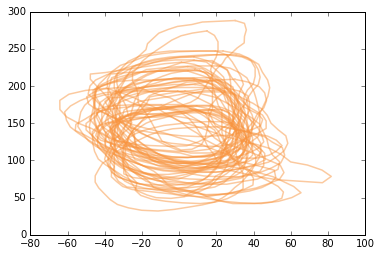

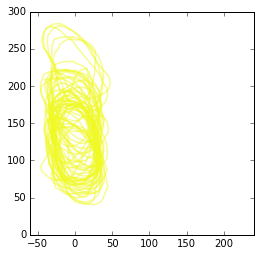

In [202]:
plot_group_masks(groupby='AgglomerativeClustering', split=True)

In [204]:
ap = cluster.AffinityPropagation()
ap.fit(pft)
labels = ap.labels_
training.loc[training['hasmask'],'AffinityPropagation'] = labels

/Users/chrisv/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


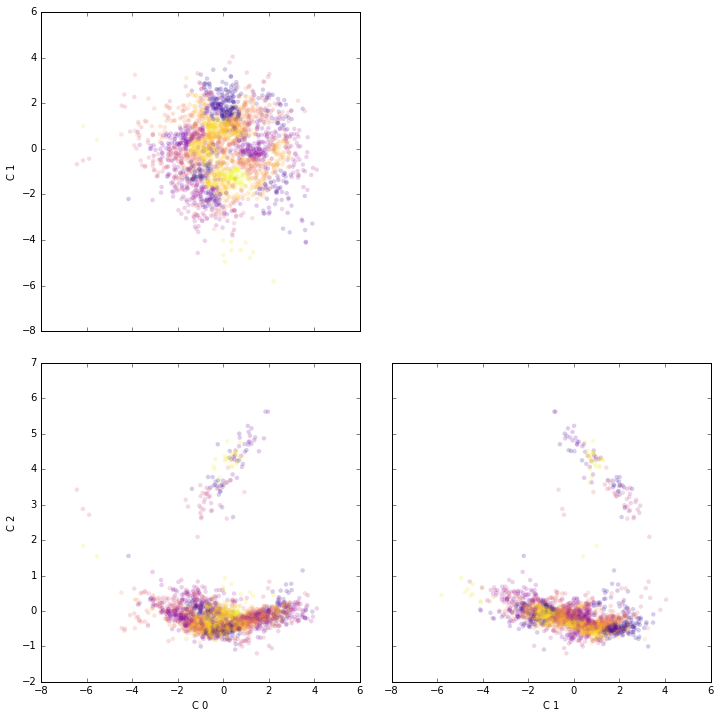

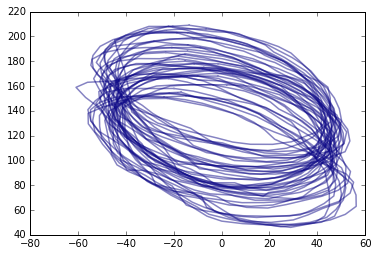

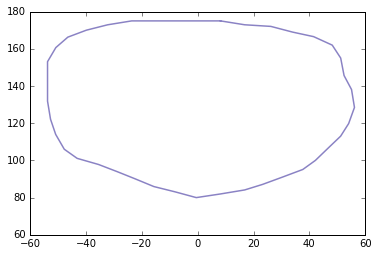

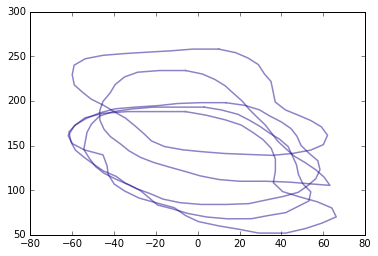

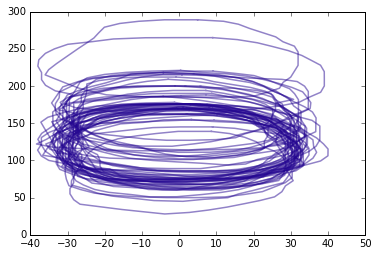

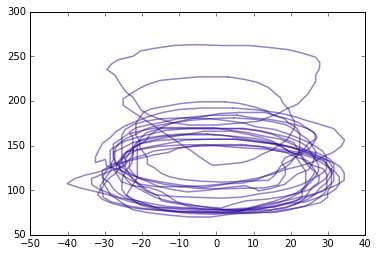

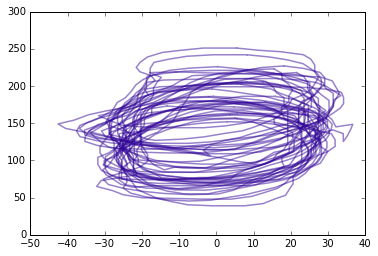

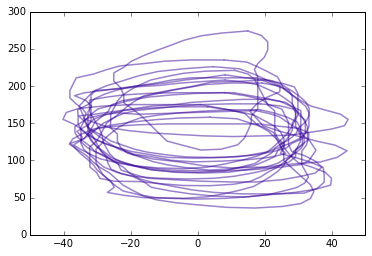

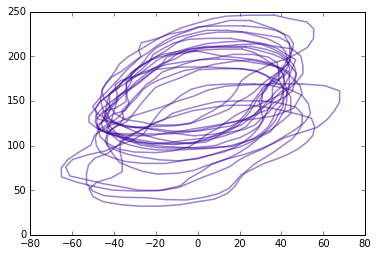

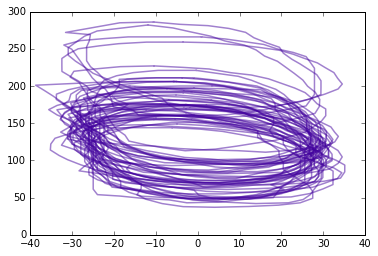

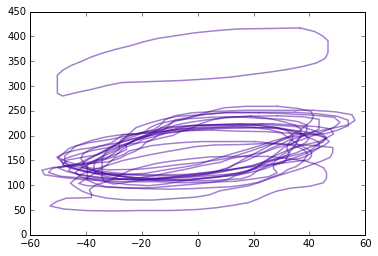

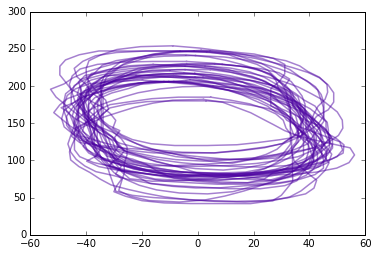

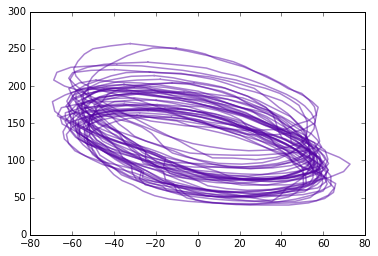

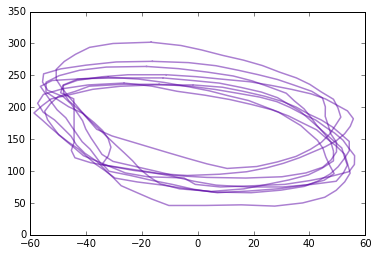

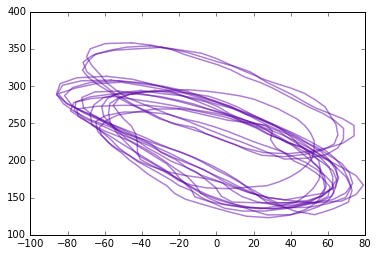

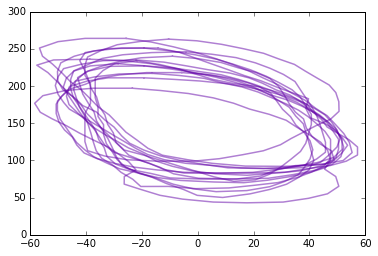

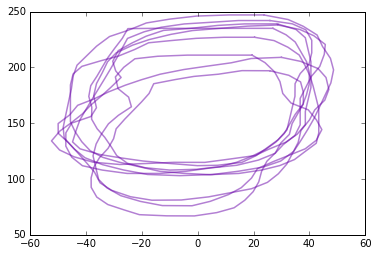

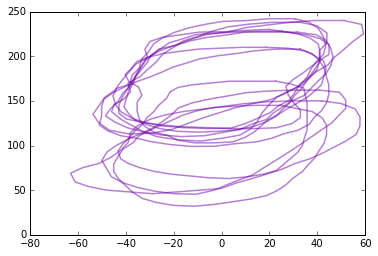

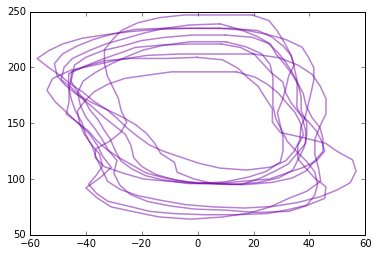

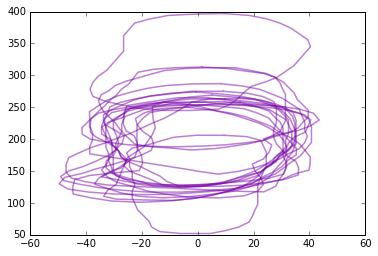

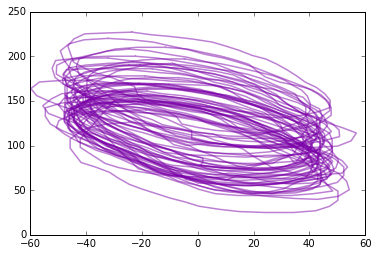

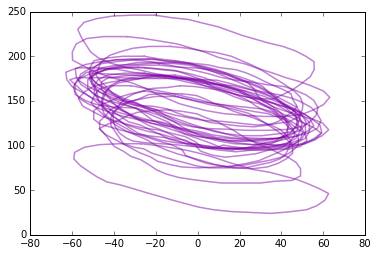

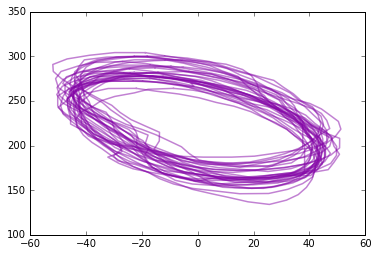

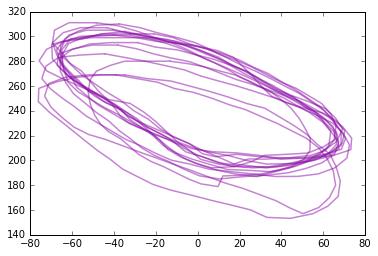

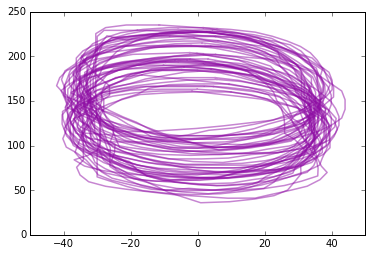

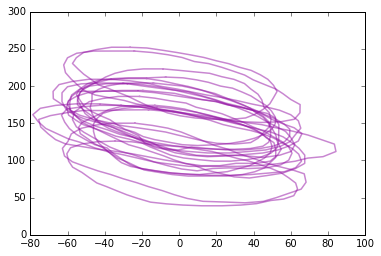

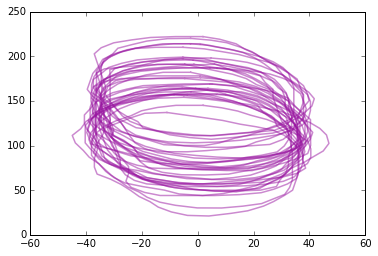

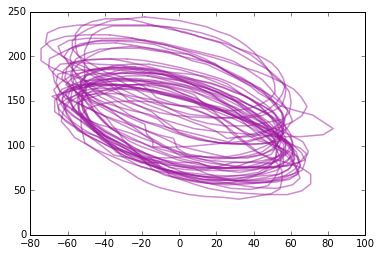

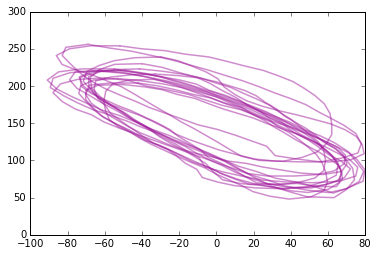

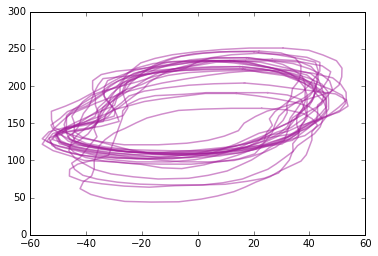

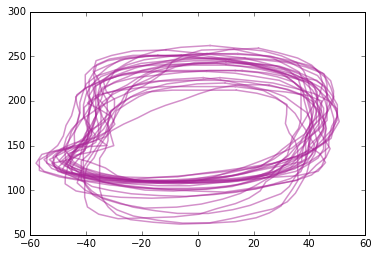

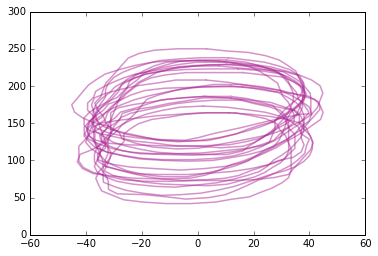

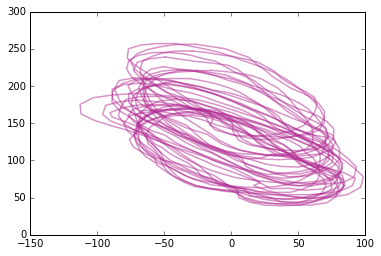

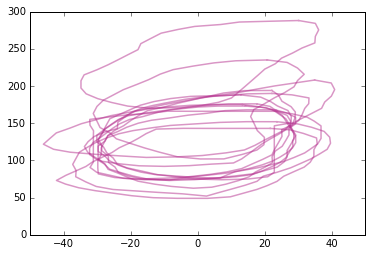

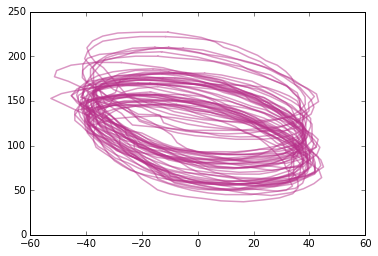

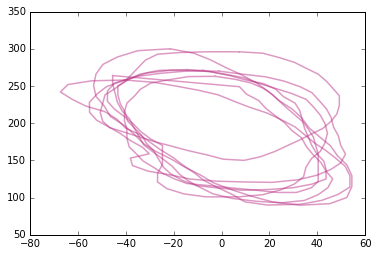

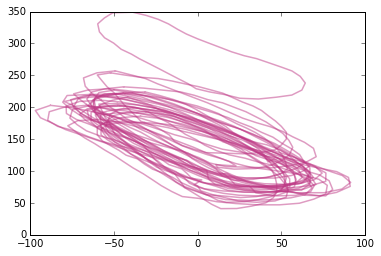

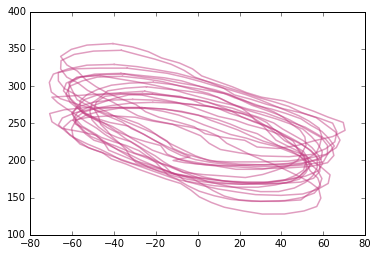

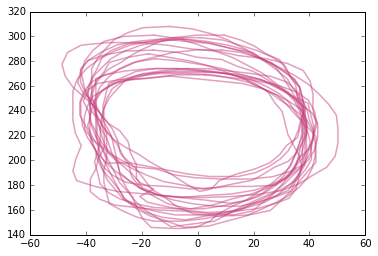

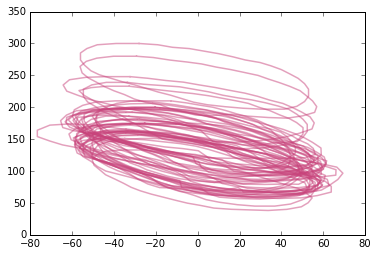

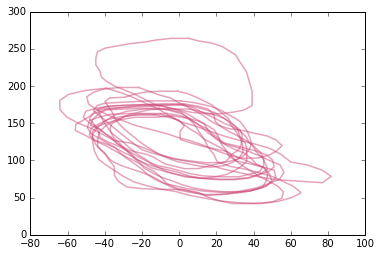

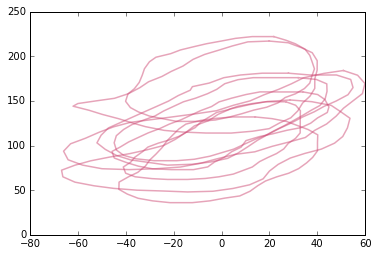

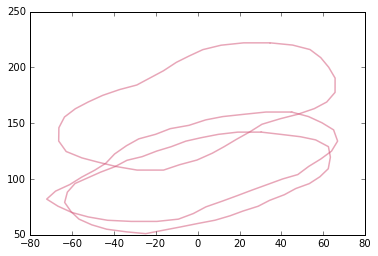

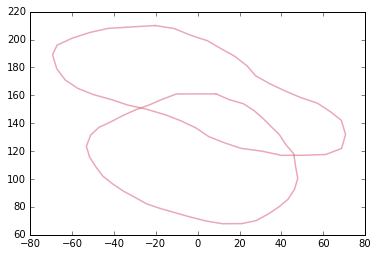

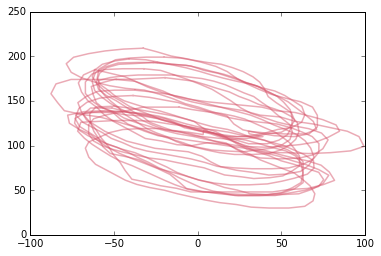

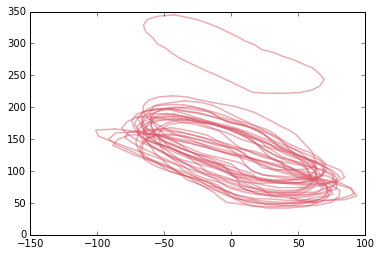

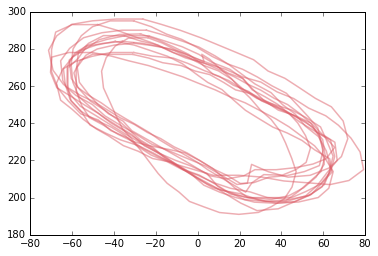

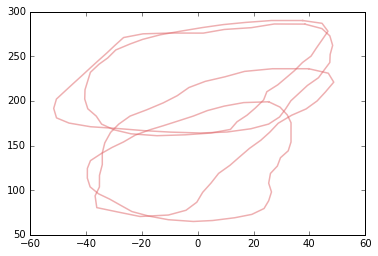

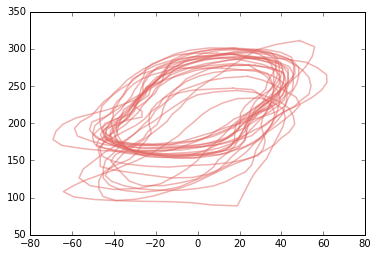

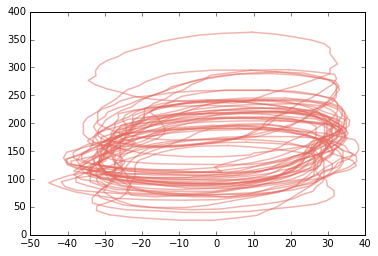

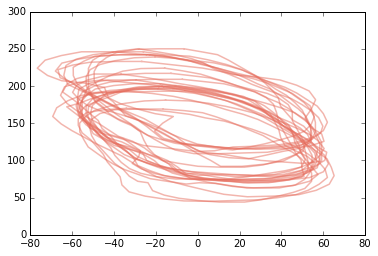

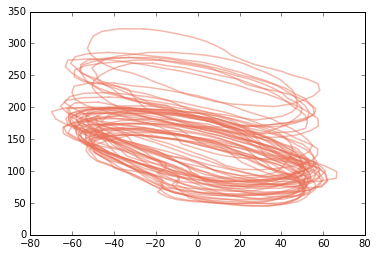

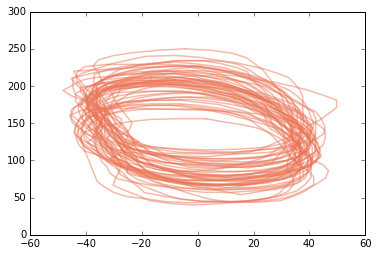

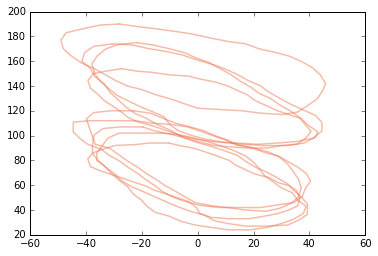

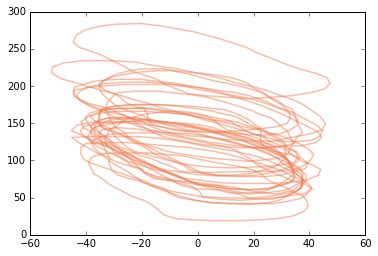

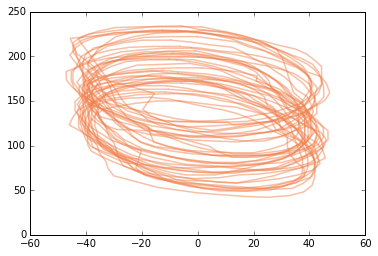

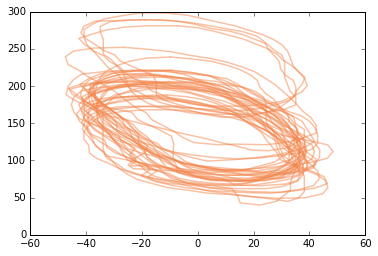

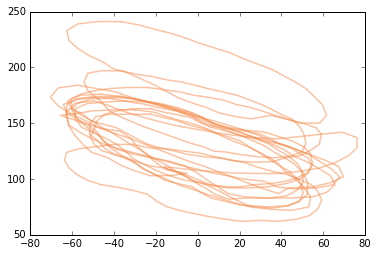

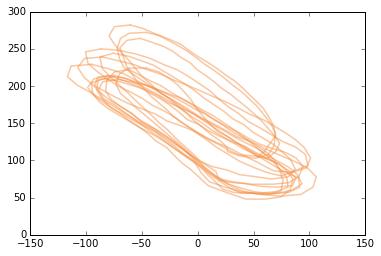

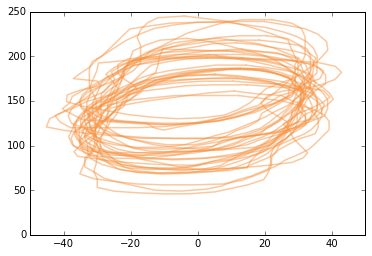

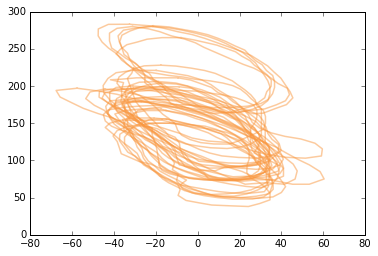

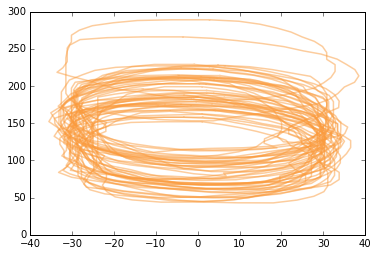

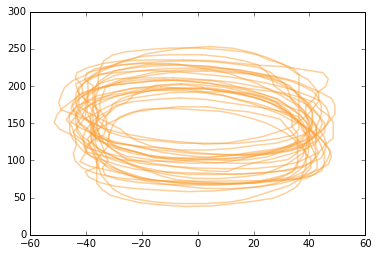

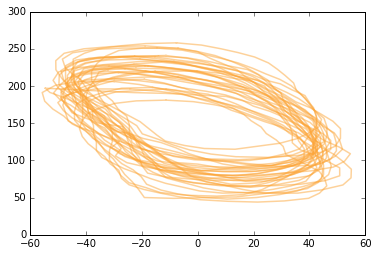

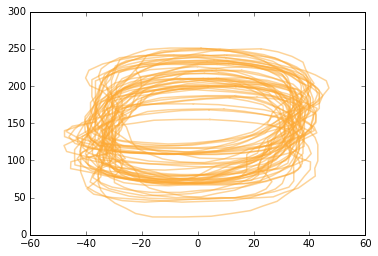

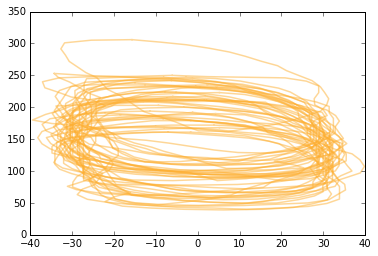

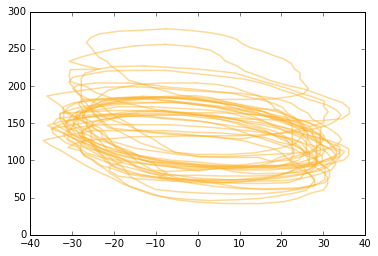

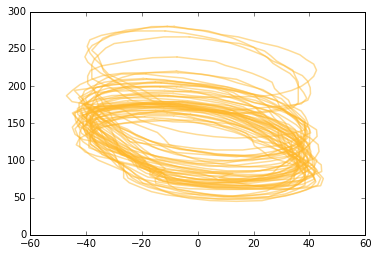

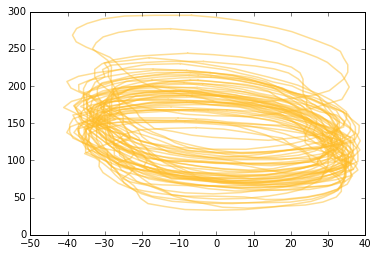

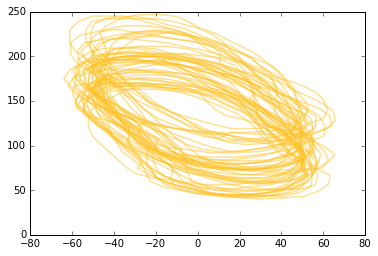

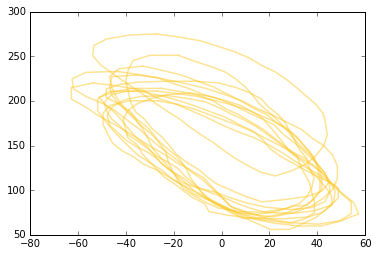

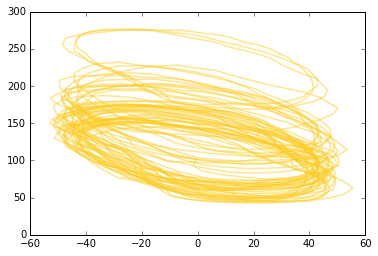

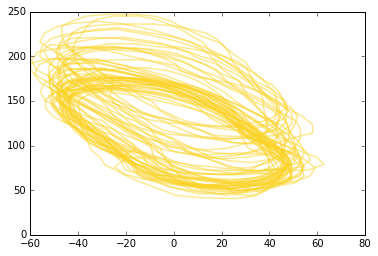

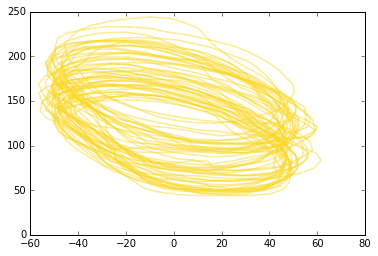

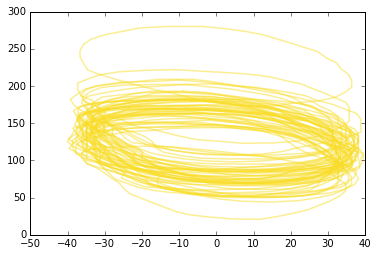

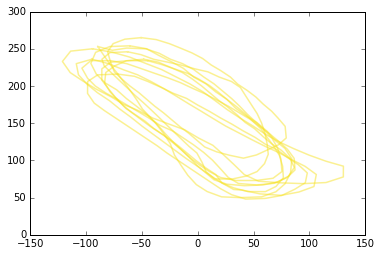

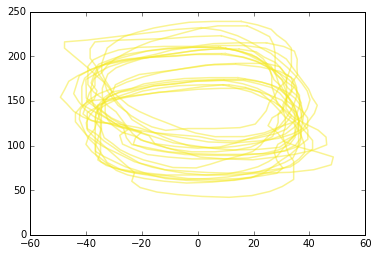

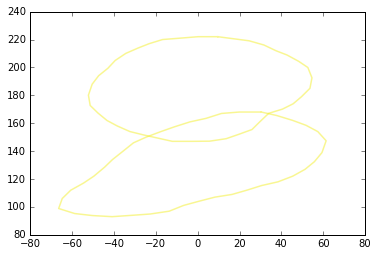

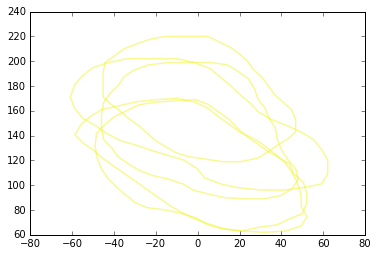

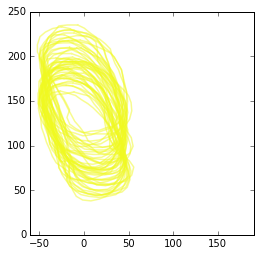

In [205]:
plot_pca_comps(pft, 3, figsize=(12,12),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=colormap(len(set(labels))))
plot_group_masks(groupby='AffinityPropagation', split=True)

0.0


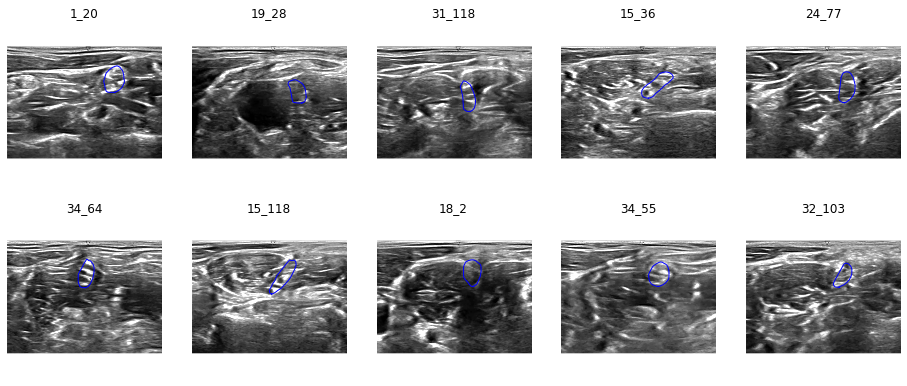

1.0


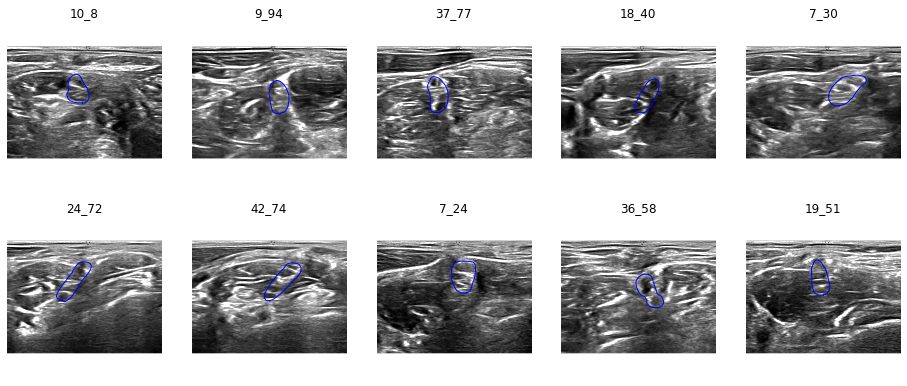

2.0


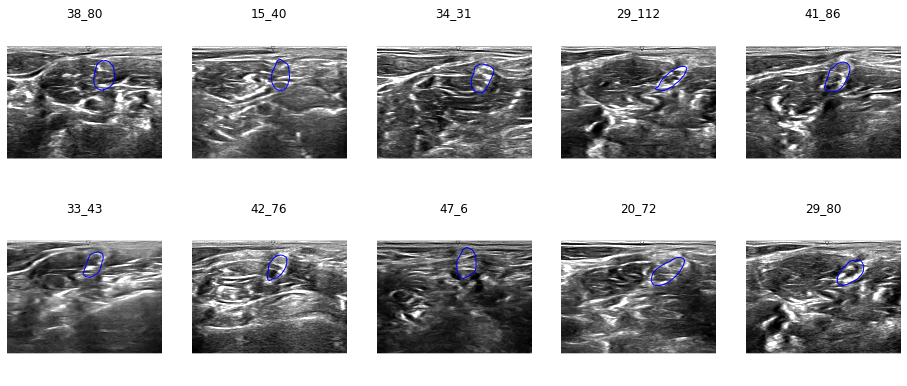

3.0


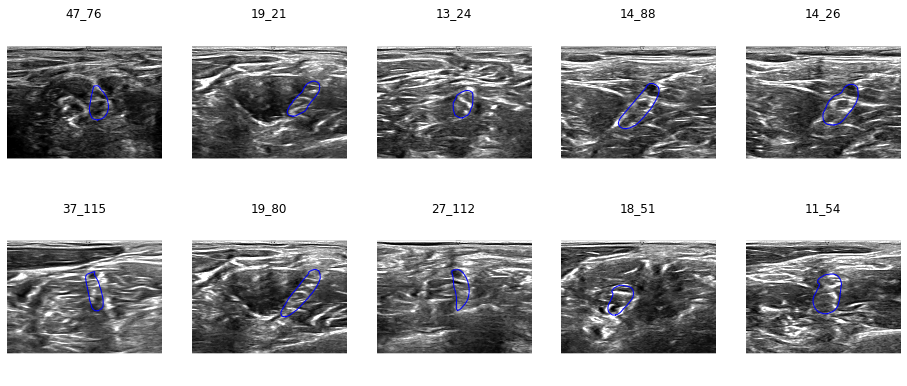

4.0


/Users/chrisv/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


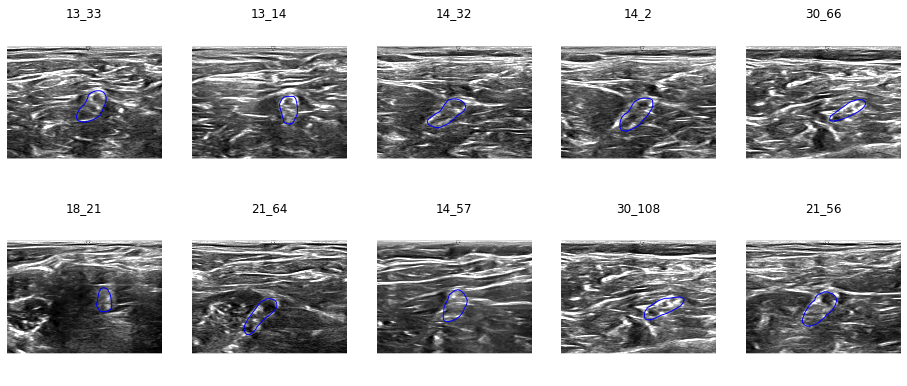

In [64]:

for key, group in clusters:
    batch = uns.batch(group.sample(n=np.min((10,len(group)))))
    print(key)
    ax = batch.plot_grid()
    plt.show()

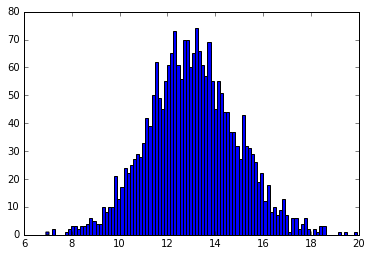

In [200]:
plt.hist(training[training.hasmask]['skelavgdist'].values*580, bins=100)
plt.show()

In [114]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=3, random_state=0)
Y = tsne.fit_transform(pft)

ValueError: array must not contain infs or NaNs

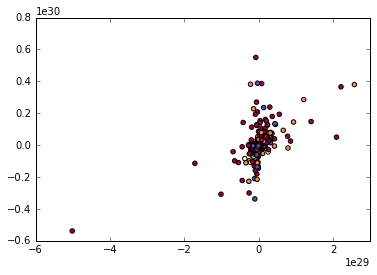

In [113]:
plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap=plt.cm.Spectral)
#plt.xlim(-.5e30,.5e30)
#plt.ylim(-1e29, 1e29)

In [108]:
from sklearn import manifold
mds = manifold.MDS(4, max_iter=100, n_init=1)
Y = mds.fit_transform(pft)

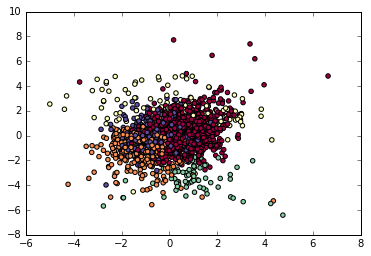

In [109]:
plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap=plt.cm.Spectral)

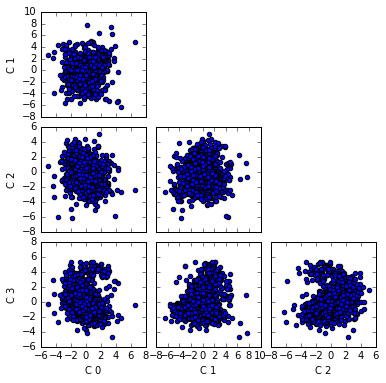

In [110]:
plot_pca_comps(Y, 4)

In [78]:
training.columns

Index(['centcol', 'centrow', 'contH', 'contW', 'contour', 'contxmax',
       'contxmin', 'contymax', 'contymin', 'hasmask', 'img', 'maskarea',
       'moment_hu_I0', 'moment_hu_I1', 'moment_hu_I2', 'moment_hu_I3',
       'moment_hu_I4', 'moment_hu_I5', 'moment_hu_I6', 'moments', 'pixels',
       'skelavgdist', 'skeldist10', 'skeldist25', 'skeldist50', 'skeldist75',
       'skeldist90', 'skelmaxdist', 'skelpixels', 'subject', 'svd', 'svdx0',
       'svdx1', 'svdy0', 'svdy1', 'unitcontour', 'sv0', 'sv1', 'sv2', 'sv3',
       'KMeansCluster', 'MeanShift', 'DBSCAN', 'AgglomerativeClustering'],
      dtype='object')

In [79]:
training.ix[0,'svd']

array([[-0.28825547,  0.14486262],
       [ 0.23319782,  0.17906447]])

In [80]:
pft.shape

(2322, 11)

In [81]:
data.shape

(2322, 18)

In [157]:
pca.components_.shape

(4, 8)

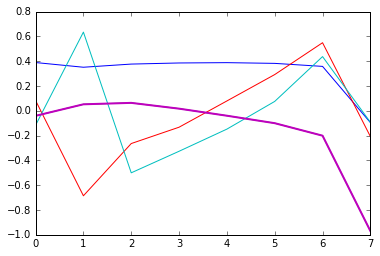

In [159]:
plt.plot(pca.components_.T)
plt.plot(pca.components_[1,:],lw=2)

In [160]:
Columns[1]

'skeldist10'